# **[Week15] Reinforcement Learning**
## **Objectives**
* Task 1: Understanding the basic problem setup and try random search
* Task 2: Q-learning
* Task 3 (optional): Deep Q-learning



## **RL Background with a Toy Example**

In Tuesday's lecture, we focused on the following environment:

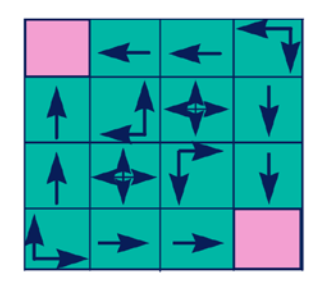

* State $s_t$ : Location (the environment has 16 different possible states)
* Action $a_t$: North, South, East, West (at each state, we have 4 possible actions)
* Reward $r_t$: -1 for each move
* Policy: A mapping from state to action (decides which action to take in the current state, in a deterministic or probabilistic manner)

GOAL: Find the best "policy" that maximizes the expected total reward earned to get to the terminal states (two pink corners)

Today, we will focus on a similar but a slightly more complicated task.

# Task 1: Understanding the basic problem setup and try random search

## **Problem Setup: Self-Driving Cab**
* There are 25 different locations in the environment.
* Among them, we have 4 important locations (R, G, Y, B), which are the possible locations for the passenger and his/her destination.
* In the example below, a passenger is waiting for the taxi at location "Y", and the destination is "R".


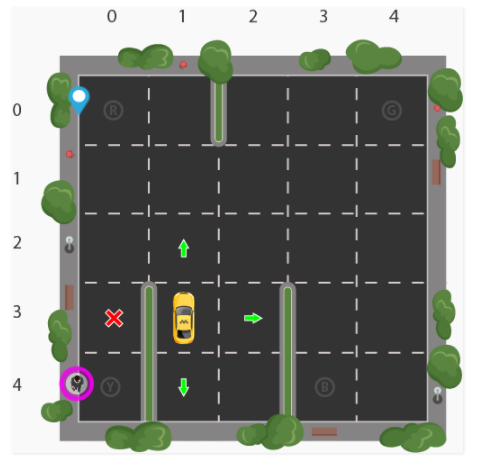

The goal of the task is to train the Smartcab so that it can pick-up the passenger, and then drop-off to the right location while saving the passenger's time.

### **1. Actions**
6 possible actions (0~5)
* 0: South
* 1: North
* 2: East
* 3: West
* 4: Pick-up
* 5: Drop-off

### **2. Rewards**
* +20 for a successful drop-off
* -1 for every time-step
* -10 for illegal pick-up and drop-off actions

### **3. States**
* There are 25 different locations for the taxi. However, the location of the passenger and the destination should be also considered.
* The passenger can be in one of the 5 locations: (R, G, B, Y, inside the taxi).
* The destination can be in one of the 4 locations: (R, G, B, Y).

Hence, the environment has 25 * 5 * 4=500 different states (0~499)

** Note that the taxi cannot perform certain actions in certain states due to walls. In such cases, the taxi won't move anywhere and the reward is simply -1 for a single time step.


## Install Gym

We will utilize OpenAI Gym that already has this exact environment.


In [ ]:
!pip install cmake 'gym[atari]' scipy

## Load environment and render how it looks like

We will use the Gym environment called Taxi-v3.

In [ ]:
import gym

env = gym.make("Taxi-v3").env

env.render()  # renders one frame of the environment (helpful in visualizing the environment)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Here, 
* The blue letter represents the current passenger pick-up location
* The purple is the current destination
* The filled sqaure represents the taxi (yellow: without passenger, green: with a passenger)
* The pipe ("|") represents a wall which the taxi cannot cross.

## Action space and state space

In [ ]:
env.reset() # reset environment to a new, random state
env.render() 

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


In [ ]:
# We can set the environment's state manually with env.s using the encoded number. You can play around with the numbers and you'll see the taxi, passenger, and destination move around.

state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index). Here, passenger index is in the range of 0~4 representing R, G, Y, B and inside the taxi. The destination index is in the range of 0~3 representing R, G, Y, B.   
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Reward table

When the Taxi environment is created, there is an initial Reward table that's also created, called "P".

In [ ]:
env.P[328]  ## reward that can be received after each action, in state 328. This dictionary has the structure {action: [(probability, nextstate, reward, done)]}.

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

This dictionary has the structure {action: [(probability, nextstate, reward, done)]}.
* 0-5 correspond to actions (south, north, east, west, pickup, dropoff).
* In this environment, probability is always 1.
* "Done" becomes True when the taxi successfully drops off a passenger in the right location. Otherwise, it is False.

## Solving the task without RL

We will first try random actions to solve this problem.

At each state, the taxi selects one random action from set of all possible actions, until successfully dropping off the passenger in the right location.

In [ ]:
env.s = 328  # set environment to illustration's state

epochs = 0
accumulated_reward, reward = 0, 0

frames = [] # for animation

done = False            

while not done:                                     # Until Success, do... 
    action = env.action_space.sample()              # automatically selects one random action from set of all possible actions.
    state, reward, done, info = env.step(action)    # step the environment by one timestep and returns state, reward, done, info. Here, "done" becomes True when the taxi successfully drops off a passenger in the right location.
                                                    # info is just an additional info such as performance and latency for debugging purposes.

                             
    accumulated_reward += reward                    # summing up the immediate rewards of all time steps


    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward,
        'accumulated reward': accumulated_reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Accumulated reward: {}".format(accumulated_reward))


Timesteps taken: 473
Accumulated reward: -1721


The below code visualizes how the taxi moves around with random actions until success.

In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        print(f"Accumulated Reward: {frame['accumulated reward']}")
        sleep(.1)

print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 473
State: 0
Action: 5
Reward: 20
Accumulated Reward: -1721


# Task 2: Solving the task with Q-Learning

## Q-table update

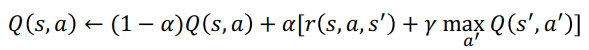

* $\alpha$: stepsize

* $\gamma$: discount factor for the reward

$Q(s,a)$ represents the quality of an action $a$ taken from the state $s$. 

Better $Q(s,a)$ implies better chances of getting greater total rewards in the long run.


## Q-Learning Process
1. Initialize the Q-table.
2. Pick a state $s$ and then "select an action $a$" (e.g., based on $\epsilon$-greedy).
3. Travel to the next state $s'$ as a result of that action $a$.
4. For all possible actions from the state $s'$ select one action $a'$ with the highest Q-value.
5. Update Q-table values using the above equation.
6. Set the next state as the current state ($s$ <-- $s'$).
7. If goal state is reached, then end and repeat steps 2~6.


Starting from an initizlied Q-table, we obtain an updated Q-table after Q-learning

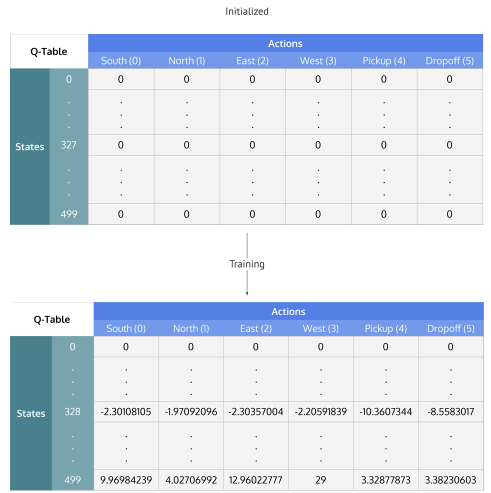

## Exploration versus Exploitation
In step 2 of the Q-learning process above, given a state $s$, how should we choose the action $a$?

 One simple ways is **"Exploitation"**: taking the best possible action according to the value function estimate $Q(s, a)$ (i.e., for a given $s$, select $a$ that maximizes $Q(s,a)$).

However, we should also gather information about uncharted (or less "explored") state-action pairs in order to have better performance.

This is **"Exploration"**: taking a random action (instead of choosing $a$ maximizing $Q(s,a)$).


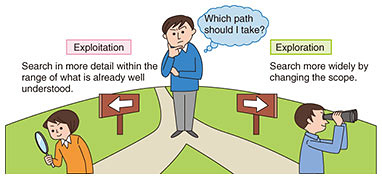

**$\epsilon$-greedy policy** takes advantage of both exploration and exploitation.

With **probability $\epsilon$**, we **take a random action** from all action space (exploration).

With **probability $1-\epsilon$**, we **choose the best action** according to the current value function (exploitation).

This method can be applied in step 2 of the Q-learning process above.

## Training

In [ ]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [ ]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1     # stesize
gamma = 0.6     # discount factor for the reward
epsilon = 0.1   # controlling the portion of exploration and exploitation

# For plotting metrics
all_epochs = []

for i in range(1, 100001):                     # Update Q-table for 100000 episodes
    state = env.reset()                        # choose an arbitrary state s

    epochs, reward, = 0, 0
    done = False
    
    while not done:                            # Until Success, do... 
        if random.uniform(0, 1) < epsilon:     # with probability epsilon, do exploration
            action = env.action_space.sample() # Explore action space
        else:                                  # with probability 1-epsilon, do exploitation
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) # next_state = s' 
        
        old_value = q_table[state, action]                # obtain Q(s,a)
        next_max = np.max(q_table[next_state])            # find Q(s',a*) where a* is the a' that maximizes Q(s',a') 
        
        ###################### Write your code here ###################
        new_value = 
        q_table[state, action] = new_value
        ###############################################################
       

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")


Episode: 100000
Training finished.

CPU times: user 1min 7s, sys: 26.4 s, total: 1min 34s
Wall time: 1min 11s


## Testing

In [ ]:
total_epochs, total_accumulated_reward = 0, 0
episodes = 100   ## test the performance of our Q-table with 100 different episodes
frames = []

for ep in range(episodes):
    state = env.reset()
    epochs, accumulated_reward, reward = 0, 0, 0
    
    done = False
    
    while not done:
        ###################### Write your code here ###################
        action =                                                          # Given a state, choose the best action according to the Q-table
        ###############################################################
        state, reward, done, info = env.step(action)

       
        accumulated_reward += reward 

        
        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'episode': ep, 
            'state': state,
            'action': action,
            'reward': reward,
            'accumulated reward': accumulated_reward 
            }
        )
        epochs += 1

    total_accumulated_reward += accumulated_reward
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average accumulated reward per episode: {total_accumulated_reward / episodes}")

Results after 100 episodes:
Average timesteps per episode: 12.82
Average accumulated reward per episode: 8.18


In [ ]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 1350
State: 85
Action: 5
Reward: 20


## (Optional) Task3 : Deep Q-Learning

### Why Deep Q-Learning?
In complicated tasks having too many states (or continuous states), Q-learning (based on Q-table) is not a practical solution.

--> Instead of constructing a Q-table, we adopt DNN to learn $Q(s,a)$ for a given $s$.

--> We would like to find $\mathbf{w}$ such that the network output $Q_\mathbf{w}(s,a)$ approximates $Q(s,a)$ well.

### Model input and output

* input: state $s$

* output: $Q_{\mathbf{w}}(s,a)$ for all actions $a$ in the action space

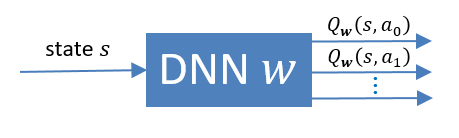

Now the question is, how to train the model? In other words, how should we set the target, and where do we get the training data? 

--> See slides 19-21 for Week 15 Lecture note!

## **Problem Setup**

cartpole Task : The agent has to move the cart left or right to prevent the pole from falling off the cart.

### **1. Actions**
2 possible actions (moving the cart left or right)
* 0: Left
* 1: Right


### **2. Rewards**
* +1 for every non-falling duration


### **3. States**
* We set the state as the difference between the current image and the previous one (By doing so, we can make the agent consider the velocity of the pole).

### **4. Network**
* Here, the state is continuous. So we can not use Q-table. To tackle this issue, we instead utilize a neural network which takes the state $s$ as input and outputs $Q$ values (in detail, $Q(s, a=left)$ and $Q(s, a=right)$ corresponging to the state $s$). Also, since the input of neural network (the state $s$) is an image (precisely, the difference between the current image and the previous image), we build a deep neural network with CNN architecture.  

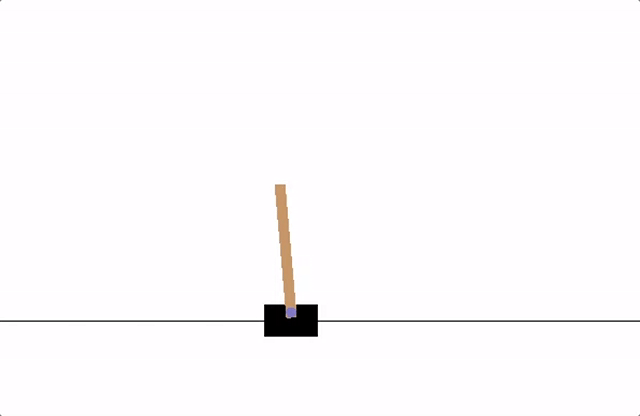

## Import necessary packages

In [1]:
import gym
import math
import random
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from time import sleep

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped


plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#For visulization

!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1200, 900))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 1s (1,277 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 71kB 11.0MB/s 


## Replay Memory

In Deep Q-Learning, we store the transitions which the agent observes into Replay Memory. And then, we sample a batch from the Replay Memory and train the model based on this.

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Deep Q network
The Deep Q network takes the difference between current image and previous image as input and based on this, outputs $Q$ values. The detail architecture of DQN is as follows:

In [4]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # This is for computing the size of CNN output
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

## Input Preprocessing
- This is for extracting and preprocessing images from the environment.

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


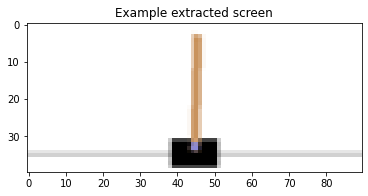

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))

    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
        
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]

    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
# Size of input (state)

print("\n The size of DQN's input (state): ", get_screen().size()) # (1, channel_size, width, height)


 The size of DQN's input (state):  torch.Size([1, 3, 40, 90])


## Solving the task wihtout RL
We will first try random actions to solve this problem. The agent choose the action (left or right) randomly. Here, for evaluation, we measure how long it lasts without falling (duration)

Duration of 0th trial: 28
Duration of 1th trial: 18
Duration of 2th trial: 12
Average Duration: 19.33


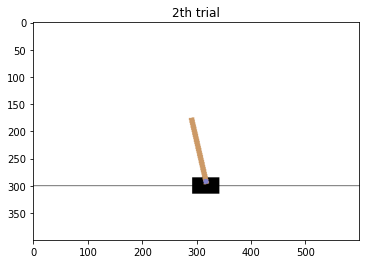

In [7]:
duration = []
for i in range(3):
    done = False
    env.reset()
    for t in count():
        #print("{}th trial".format(i))
        action = env.action_space.sample() # Sample an arbitrary action 
        obs, reward, done, info = env.step(action) # Observe a new state and reward from the environment given the action

        # Plot the current situation
        screen = env.render(mode='rgb_array')
        plt.imshow(screen)
        plt.title("{}th trial".format(i))
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
      
        if done:
            print("Fail")
            duration.append(t+1)
            sleep(2)
            break

ipythondisplay.clear_output(wait=True)
env.close()

for t in range(3):
    print("Duration of {}th trial: {}".format(t,duration[t]))
print("Average Duration: {:.2f}".format(sum(duration)/len(duration)))

## Hyperparameters and necessary function

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get a current screen
init_screen = get_screen() 

# Get the size of screen so that we can initialize layers of our DQN correctly (the shape of an input is 3x40x90)
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

# policy network is actually a network for predicting actions which represents the agent.
policy_net = DQN(screen_height, screen_width, n_actions).to(device)

# target network is just a network which compute the target value (y_t) in the lecture note for stability. 
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

#Define an optimizer
optimizer = optim.RMSprop(policy_net.parameters())

#Prepare Replay Memory
memory = ReplayMemory(10000)


steps_done = 0


# This function choose the action given state, based on trained policy network.
# This represents the decision of the agent.
def select_action(state):
    global steps_done

    sample = random.random()

    # decay the epsilon according to time step
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # epsilon greedy 
    if sample > eps_threshold:                                                                # with probability 1-epsilon, do exploitation
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)                                     # Exploit learned values (search an action which has the maximum Q value represented by policy net)
    else:                                                                                     # with probability epsilon, do exploration
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long) # Explore action space (take an action randomly)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

## Training function

The training is implemented based on Q-Learning and the details are as follows: 

In [7]:
def optimize_model():
    # If the number of samples in the memory is less than batch size, we have to collect more samples.
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE) # a list with 128 samples and each sample has (state, action, next_state, reward)

    # Make a batch
    batch = Transition(*zip(*transitions)) # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for detailed explanation). 
                                           # This converts batch-array of Transitions to Transition of batch-arrays.

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s, a) given state s for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute y_t in the lecture.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss by comparing the output of Q_wq network(policy net) and Q_wtg(target net) as in the lecture note
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

## Training the DQN

In this code, we first collect the experiences from the environment and save the samples into memory. And then, we sample a batch from the memory and based on this, we train the Deep Q network.

In [8]:

# For meaningful performance improvements, you have to run more than 2000 episodes.
num_episodes = 500



for i_episode in tqdm(range(num_episodes)):

    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action given current state
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            
            break
    # Update the target network, copying all weights and biases in polich network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

100%|██████████| 2000/2000 [17:47<00:00,  1.87it/s]

Complete


## Evaluation of the trained DQN

We can confirm that the duration of DQN is longer than when randomly selecting an action.

Duration of 0th trial: 57
Duration of 1th trial: 62
Duration of 2th trial: 78
Average Duration: 65.67


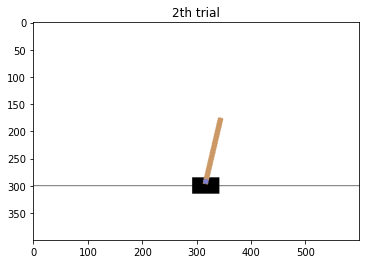

In [12]:
duration = []

for i in range(3):
    obs, done, rew = env.reset(), False, 0
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        action = select_action(state)
        observation, reward, done, _ = env.step(action.item())
        
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Move to the next state
        state = next_state
        
        screen = env.render(mode='rgb_array')
        plt.imshow(screen)
        plt.title("{}th trial".format(i))
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if done:
            print("Fail")
            duration.append(t+1)
            sleep(2)
            break

ipythondisplay.clear_output(wait=True)
env.close()

for t in range(3):
    print("Duration of {}th trial: {}".format(t,duration[t]))
print("Average Duration: {:.2f}".format(sum(duration)/len(duration)))

# Reference

This practice session material is heavily based on the links below:

https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
https://www.kaggle.com/karthikcs1/reinforcement-learning-taxi-v3-openai
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#input-extraction